<CENTER>
David P. Chassin, Staff Scientist<BR/>
Grid Integration Systems and Mobility (GISMo)<BR/>
Applied Energy Division<BR/>
SLAC National Accelerator Laboratory<SUP>1</SUP>, Menlo Park, California (USA)
<BR/>and<BR/><BR/>
Lynne Kiesling, Co-Director<BR/>
Institute for Regulatory Law & Economics (IRLE)<BR/>
Wilton E. Scott Institute for Energy Innovation<BR/>
Carnegie Mellon University, Pittsburgh, Pennsylvania (USA)<BR/>
</CENTER>

<SUP>1</SUP> SLAC National Accelerator Laboratory is operated for the US Department of Energy by Stanford University under Contract DE-AC02-76SF00515.  This work was funded by the US Department of Energy Office Electricity, Office of Building Technology, Solar Energy Technology Office, ARPA-E, and the California Energy Commission under grants EPC-17-043, EPC-17-046, and EPC-17-047.

A Transactive Energy system may use an Orderbook to implement a continuous market rather than a discrete-time double auction [1].  In an Orderbook, two lists of limit orders are maintained and market orders are filled in real-time.

Limit orders are used to inform the market of the availability of a resource to supply (sell or "ask" order are usually denoted $A$) or consume (buy or "bid" order are usually denoted $B$) a specified quantity of service at a specified price for a specified duration.  In general limit orders are used to announce that a resource is potentially available given the right price, but otherwise the resource will not operate.

Market orders are used to obtain from the market an immediate commitment of a resource to supply or consume at the best price possible at the present time.  In general market orders are used to announce that a resource must operate immediately and will do so at the best available price.  The only price guarantee that the resource has is the price will be no higher that lowest ask and no lower than the highest bid, given the quantity and duration constraints provided.

When a supplier and consumer are matched the resulting cleared orders (denoted $C$) are returned to both parties with the additional information pertaining to the amount and cost of clearing the orders.

For a supplier and consumer to match, their orders must have the following characteristics, which are referred to as the *clearing rules*.

1. The cleared ask must have a price greater than or equal to the submitted ask.
2. The cleared bid must have a price less than or equal to the submitted bid.
3. The intersection of the ask and bid time intervals must be non-null.
4. If the bid is indivisible, the the ask quantity must be greater than or equal to the bid quantity, and the bid time interval must be the same as or a sub-interval of the ask time interval.
5. If the ask is indivisible, then the bid quantity must be less than or equal to the ask quantity, and the ask time interval must be the same as or a sub-interval of the bid time interval.

This document describes the types of orders and the market mechanisms needed to implement a Transactive Orderbook based on these clearing rules.

# Market Units

Each Orderbook tracks a product or service specified as a "unit".  In this document, we will use the unit of megaWatt (denoted MW) in the examples.  However, other units may also be supported. Time duration units can also be specified, and this document will use the time unit "h" in the examples. The currency unit used is "$".

# Order Parameters
Orders have a number of parameters associated that are used to characterize them, as shown in Table 1.

<BR/><CENTER>Table 1 - Order parameters</CENTER>

| Parameter | Default | Description |
| :-------: | :-----: | :---------- |
| Quantity | MW | The quantity bid or ask |
| Price | $/MW.h | The bid or ask price |
| Duration | h | The duration of the ask/offer |
| Divisibility | varies | The order divisibility flag |
| Amount | - | The amount filled (if any) |
| Cost | - | The cost of filling the order (if any) |

## Quantity
The quantity associated with a particular order is always given in the Orderbook's unit. If the quantity is divisible, the order must indicate that.

## Duration
Every order has duration associated with it over which the order is expected to be filled. If the duration is divisible, then the order must indicate that. 

The total amount traded is always for the order quantity multiplied by the order duration.

## Price
The price associated with an order is always given per unit quantity per unit time.

## Divisibility
Order may be filled using multiple orders. However, if a limit order cannot be filled immediately, a divisible order may be partly filled and the remainder of the order placed in the order book to be filled at the first opportunity.  To specify that an order must be filled in its entirety when it initially filled, it must be specified as indivisible by setting the divisibility flag to `False`.  By default sell orders are divisible, and buy orders are indivisible. Indivisible market orders must be fully filled immediately in quantity but can be filled sequentially in time by different sell orders provided there are not gaps in filling the order in time.

## Amount

The order amount is the product of the quantity filled multiplied by the duration over which it has been filled. No portion of the quantity or duration may remain unfilled once the order is cleared.  If any portion of a divisible order remain unfilled, the order must be divided into the cleared portion (with the amount set), and at most two new orders that account for the residual unfilled order.  If an order must be divided, it must first be divided in time (if necessary), then in quantity (if necessary).

## Cost

The cost of an order is computed when the order is filled and the amount has been computed. The order cost is the total traded amount multiplied by the trade price.  The trade price is the price that clears the corresponding order. The trade price may be different from the order price, depending on the clearing price algorithm. A positive amount is associated with a sell order at a positive price, and negative amount is associated with a buy order at a positive price.  Note that negative prices are permitted, but represent a market pathology associated with insufficient resources.

# Limit Orders

There are two types of limit orders in an Orderbook system: Buy Limit and Sell Limit.

## Buy Limit
A Buy Limit is a "bid" order to buy only if one or more sellers can be found who are willing to deliver the given amount (the quantity multipled by the duration) at the given price. A buy limit order remains in the book until it is canceled or it expires.

## Sell Limit
A Sell Limit is an "ask" order to sell only if one or more buyers can be found who are willing to consume the given amount (quantity multiplied by duration) at the given price. A sell limit order remains in the book until it is canceled or it expires.

# Market Orders
There are two types of market orders in an Orderbook system: Buy Market and Sell Market.

## Buy Market

A Buy Market is a "bid" order to buy a given amount immediately at the best available price. If the order cannot be filled immediately, the order is canceled.

## Sell Market

A Sell Market is an "ask" order sell a given amount immediately at the best available price.  If the order cannot be filled immediately, the order is canceled.

# Filling Orders

Orders are filled when they are received, if possible. The disposition of orders that cannot be filled immediately depends on the type of order; a limit order is placed on the books while a market order is cancelled.

When an order is filled, the quantity, duration, price, and value are set and the order status data is returned to the agent. Depending on the order parameters, the order may not be filled completely, or the order may be canceled.

## Clearing Price

One important question is whether orders get filled as bid/ask or there is a formula for splitting the difference. If a cost-free central market clearing agent is used, then one can divide the difference equally so that $P_c=\frac{1}{2}(P_a+B_b)$. Alternatively, an arbitrary fraction of the difference can be paid to the market clearing agent. Another approach is to impose a fixed fee on both asks and bids to pay the market clearing agents regardless of the difference and divide the difference among the parties.

In an untrusted environment the preferred method is to pay as asked, charge as bid, and deliver the difference as payment to the first $\frac{N}{2}+1$ agents that correctly solve the market clearing problem. Thus the difference in ask/bid prices, if any, can be used to provide an incentive for agents to participate in a distributed market clearing system. On the one hand there is an incentive for agents to join in the clearing system, but on the other hand, if too many agents join, then the incentives diminishes to become infinitessimal.  In principle, an equilibrium is reached at which the cost of an agent supporting the clearing service is slightly less than the revenue derived from participating in it.

## Filling Limit Orders
A limit order is filled immediately if a matching limit order in the other book can be found.  For example, if a Sell Limit is received for a price less than or equal to the highest Buy Limit order, then the Sell Limit order is filled with the corresponding Buy Limit order.  If the order quantity is divisible, then this process is continued until the Sell Limit order is completely filled or there are no remaining Buy Limit orders that match at the given price. The balance of the limit order is left on the books to be filled at a later date. If the order quantity is not divisible, then the order must be filled completely, otherwise it must be placed in the book to be filled later.

### Examples
To run the python examples, you must load the `orderbook.py` module

In [1]:
import orderbook as ob

This example creates one order of each type. Note that by default sell orders are divisible and buy orders are not divisible. Also note that until the order are submitted to a market, they have not defined unit, time, or currency.

In [2]:
print(ob.order(order_type="BUYLIMIT",quantity=10.0,price=10.0,duration=1.0))
print(ob.order(order_type="SELLLIMIT",quantity=10.0,price=10.0,duration=1.0))
print(ob.order(order_type="BUYMARKET",quantity=5.0, duration=1.0))
print(ob.order(order_type="SELLMARKET",quantity=5.0, duration=1.0))
print(ob.order(order_type="CANCEL",quantity=1.0,duration=1.0))

<order:0 BUYLIMIT INDIVISIBLE 10.0 at 10.0 for 1.0>
<order:1 SELLLIMIT 10.0 at 10.0 for 1.0>
<order:2 BUYMARKET INDIVISIBLE 5.0 for 1.0>
<order:3 SELLMARKET 5.0 for 1.0>
<order:4 CANCEL 1.0 for 1.0>


This example builds buy and sell books and displays them visually.  The x-axis is the price, and the y-axis is the cumulative quantity.

{"buy": [{"quantity": 1.5, "duration": 1.0, "price": 8.0, "id": 8, "ordertype": "BUYLIMIT", "amount": 0.0, "value": 0.0, "divisible": false}, {"quantity": 1.0, "duration": 1.0, "price": 5.0, "id": 9, "ordertype": "BUYLIMIT", "amount": 0.0, "value": 0.0, "divisible": false}, {"quantity": 2.5, "duration": 1.0, "price": 2.0, "id": 10, "ordertype": "BUYLIMIT", "amount": 0.0, "value": 0.0, "divisible": false}], "sell": [{"quantity": 2.0, "duration": 1.0, "price": 10.0, "id": 5, "ordertype": "SELLLIMIT", "amount": 0.0, "value": 0.0, "divisible": true}, {"quantity": 1.0, "duration": 1.0, "price": 15.0, "id": 6, "ordertype": "SELLLIMIT", "amount": 0.0, "value": 0.0, "divisible": true}, {"quantity": 0.5, "duration": 1.0, "price": 20.0, "id": 7, "ordertype": "SELLLIMIT", "amount": 0.0, "value": 0.0, "divisible": true}], "unit": "MW", "time": "h", "currency": "$", "price": "$/MW.h", "using": {}, "fees": 0.0, "settled": []}


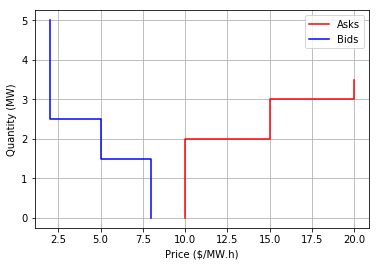

In [3]:
market = ob.orderbook()
market.ask(quantity=2.0, duration=1.0, price=10.0)
market.ask(quantity=1.0, duration=1.0, price=15.0)
market.ask(quantity=0.5, duration=1.0, price=20.0)
market.bid(quantity=1.5, duration=1.0, price=8.0)
market.bid(quantity=1.0, duration=1.0, price=5.0)
market.bid(quantity=2.5, duration=1.0, price=2.0)
print(market)
graph = market.plot(using={"grid":"","legend":"['Asks','Bids']"})

The following adds a sell limit order that can be satisfied by the highest buy limit order.

<order:11 SELLLIMIT FILLED 1.5MWh for 12.0$>
{"buy": [{"quantity": 1.0, "duration": 1.0, "price": 5.0, "id": 9, "ordertype": "BUYLIMIT", "amount": 0.0, "value": 0.0, "divisible": false}, {"quantity": 2.5, "duration": 1.0, "price": 2.0, "id": 10, "ordertype": "BUYLIMIT", "amount": 0.0, "value": 0.0, "divisible": false}], "sell": [{"quantity": 2.0, "duration": 1.0, "price": 10.0, "id": 5, "ordertype": "SELLLIMIT", "amount": 0.0, "value": 0.0, "divisible": true}, {"quantity": 1.0, "duration": 1.0, "price": 15.0, "id": 6, "ordertype": "SELLLIMIT", "amount": 0.0, "value": 0.0, "divisible": true}, {"quantity": 0.5, "duration": 1.0, "price": 20.0, "id": 7, "ordertype": "SELLLIMIT", "amount": 0.0, "value": 0.0, "divisible": true}], "unit": "MW", "time": "h", "currency": "$", "price": "$/MW.h", "using": {"grid": "", "legend": "['Asks','Bids']"}, "fees": 0.0, "settled": [{"quantity": 0.0, "duration": 1.0, "price": 8.0, "id": 8, "ordertype": "BUYLIMIT", "amount": 1.5, "value": -10.5, "divisible":

{'sell': [[<matplotlib.lines.Line2D at 0x115b14550>]],
 'buy': [[<matplotlib.lines.Line2D at 0x115b14978>]],
 'figure': <Figure size 432x288 with 1 Axes>,
 'plot': <module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>}

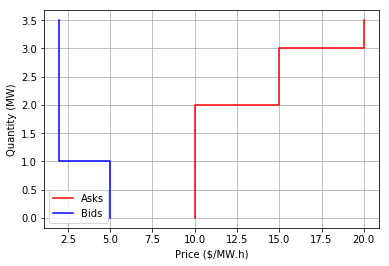

In [4]:
print(market.ask(quantity=1.5,duration=1.0,price=7.0))
print(market)
market.plot()

<order:12 BUYLIMIT FILLED 1.5MWh for -15.0$>
{"buy": [{"quantity": 1.0, "duration": 1.0, "price": 5.0, "id": 9, "ordertype": "BUYLIMIT", "amount": 0.0, "value": 0.0, "divisible": false}, {"quantity": 2.5, "duration": 1.0, "price": 2.0, "id": 10, "ordertype": "BUYLIMIT", "amount": 0.0, "value": 0.0, "divisible": false}], "sell": [{"quantity": 0.5, "duration": 1.0, "price": 10.0, "id": 5, "ordertype": "SELLLIMIT", "amount": 1.5, "value": 16.5, "divisible": true}, {"quantity": 1.0, "duration": 1.0, "price": 15.0, "id": 6, "ordertype": "SELLLIMIT", "amount": 0.0, "value": 0.0, "divisible": true}, {"quantity": 0.5, "duration": 1.0, "price": 20.0, "id": 7, "ordertype": "SELLLIMIT", "amount": 0.0, "value": 0.0, "divisible": true}], "unit": "MW", "time": "h", "currency": "$", "price": "$/MW.h", "using": {"grid": "", "legend": "['Asks','Bids']"}, "fees": 0.0, "settled": [{"quantity": 0.0, "duration": 1.0, "price": 8.0, "id": 8, "ordertype": "BUYLIMIT", "amount": 1.5, "value": -10.5, "divisible"

{'sell': [[<matplotlib.lines.Line2D at 0x115c0bc18>]],
 'buy': [[<matplotlib.lines.Line2D at 0x115c0bd68>]],
 'figure': <Figure size 432x288 with 1 Axes>,
 'plot': <module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>}

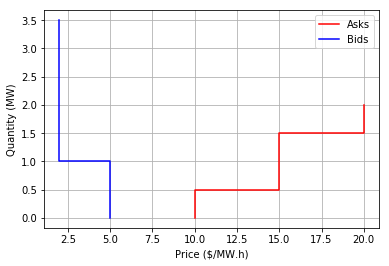

In [5]:
print(market.bid(quantity=1.5,duration=1.0,price=11.0))
print(market)
market.plot()

## Filling Market Orders
A market order is filled immediately using the corresponding book. If an order is divisible, then it may be only partly filled and the balance of the order is canceled. If the order is indivisible and it cannot be completely filled, then it is canceled.

### Examples

The following example illustrates an indivisible market buy order.

<order:13 BUYMARKET FILLED 1.0MWh for -12.5$>


{'sell': [[<matplotlib.lines.Line2D at 0x115cfee48>]],
 'buy': [[<matplotlib.lines.Line2D at 0x115cfef98>]],
 'figure': <Figure size 432x288 with 1 Axes>,
 'plot': <module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>}

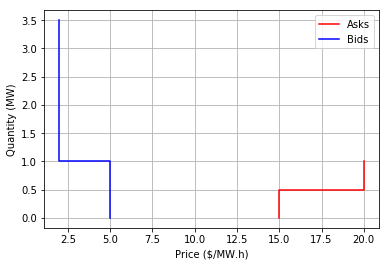

In [6]:
print(market.bid(quantity=1.0,duration=1.0))
market.plot()

The following example illustrates an market sell order.

<order:14 SELLMARKET FILLED 1.0MWh for -5.0$>


{'sell': [[<matplotlib.lines.Line2D at 0x115df8208>]],
 'buy': [[<matplotlib.lines.Line2D at 0x115df8630>]],
 'figure': <Figure size 432x288 with 1 Axes>,
 'plot': <module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>}

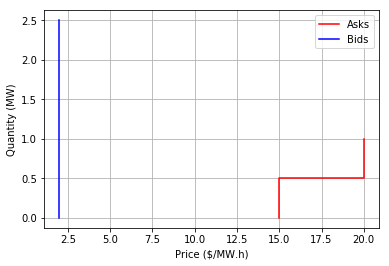

In [7]:
print(market.ask(quantity=1.0,duration=1.0))
market.plot()

The following example illustrates an attempt to less than is required by the remaining buyer. 

<order:15 CANCEL 1.0MW for 1.0h>


{'sell': [[<matplotlib.lines.Line2D at 0x115ee4518>]],
 'buy': [[<matplotlib.lines.Line2D at 0x115ee4908>]],
 'figure': <Figure size 432x288 with 1 Axes>,
 'plot': <module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>}

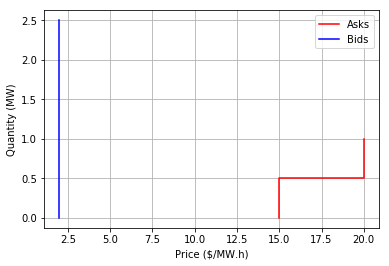

In [8]:
print(market.ask(quantity=1.0,duration=1.0))
market.plot()

# Order Duration

When an order has mismatched duration, the dispatch must be updated when the time has elapsed.  For example, if seller $A$ places an order with a duration of 30 minutes, while matched buyer $B$'s order duration is 1 hour, then the $B$ must be rebooked to find a new $A$ for the unfilled balance of the 30 minutes.  Until a new $A$ can be found $B$ must be suspended, and thus $B$ must be divisible. If $B$ is indivisible, it cannot be filled, and it $B$ is a market order, it must be cancelled.

A complete formulation of duration resolution is as follows:

$
A(Q_a,P_a,T,D_a) + B(Q_b,P_b,T,D_b)
\to \\~\\
\left\{ \begin{array}{lcl}
    Q_a < Q_b &:& 
    \left\{ \begin{array}{lcl}
        D_a < D_b &:& C(Q_a,P_c,T,D_a) + B_1(Q_b-Q_a,P_b,T,D_a) + B_2(Q_b,P_b,T+D_a,D_b-D_a)
    \\
        D_a = D_b &:& C(Q_a,P_c,T,D_a)+B_1(Q_b-Q_a,P_b,T,D_b)
    \\
        D_a > D_b &:& C(Q_a,P_c,T,D_b) + B_1(Q_b-Q_a,P_b,T,D_b) + A_1(Q_a,P_a,T+D_b,D_a-D_b)
    \end{array} \right.
\\~\\
    Q_a = Q_b &:&
    \left\{ \begin{array}{lcl}
        D_a < D_b &:& C(Q_a,P_c,T,B_1) + B_1(Q_b,P_b,T+D_a,D_b-D_b)
    \\
        D_a = D_b &:& C(Q_a,P_c,T,D_a)
    \\
        D_a > D_b &:& C(Q_a,P_c,T,D_b)+A_1(Q_a,P_a,T,D_a-D_b)
    \end{array} \right.
\\~\\
    Q_a > Q_b &:&
    \left\{ \begin{array}{lcl}
        D_a < D_b &:& C(Q_b,P_c,T,D_a) + A_1(Q_a-Q_b,P_a,T,D_a) + B_1(Q_b,P_b,T+D_a,D_b-D_a)
    \\
        D_a = D_b &:& C(Q_b,P_c,T,D_a) + A_1(Q_a-Q_b,P_a,T,D_a)
    \\
        D_a > D_b &:& C(Q_b,P_c,T,D_b) + A_1(Q_a-Q_b,P_a,T,D_b) + A_2(Q_a,P_a,T+D_b,D_a-D_b)
    \end{array} \right.
\end{array} \right.
$

where $P_C=\frac{1}{2}P_A+\frac{1}{2}P_B$.

This can be represented schematically according to the following cases

### Case 1
$(Q_a<Q_b) \vee (D_a<D_b) \implies A(Q_a,P_a,T,D_a) + B(Q_b,P_b,T,D_b) \to C(Q_a,P_c,T,D_a) + B_1(Q_b-Q_a,P_b,T,D_a) + B_2(Q_b,P_b,T+D_a,D_b-D_a)$ 

### Case 2
$(Q_a<Q_b) \vee (D_a=D_b) \implies A(Q_a,P_a,T,D_a) + B(Q_b,P_b,T,D_b) \to C(Q_a,P_c,T,D_a)+B_1(Q_b-Q_a,P_b,T,D_b)$

### Case 3
$(Q_a<Q_b) \vee (D_a>D_b) \implies A(Q_a,P_a,T,D_a) + B(Q_b,P_b,T,D_b) \to C(Q_a,P_c,T,D_b) + B_1(Q_b-Q_a,P_b,T,D_b) + A_1(Q_a,P_a,T+D_b,D_a-D_b)$

### Case 4
$(Q_a=Q_b) \vee (D_a<D_b) \implies A(Q_a,P_a,T,D_a) + B(Q_b,P_b,T,D_b) \to C(Q_a,P_c,T,B_1) + B_1(Q_b,P_b,T+D_a,D_b-D_b)$

### Case 5
$(Q_a=Q_b) \vee (D_a=D_b) \implies A(Q_a,P_a,T,D_a) + B(Q_b,P_b,T,D_b) \to C(Q_a,P_c,T,D_a)$

### Case 6
$(Q_a=Q_b) \vee (D_a>D_b) \implies A(Q_a,P_a,T,D_a) + B(Q_b,P_b,T,D_b) \to C(Q_a,P_c,T,D_b)+A_1(Q_a,P_a,T,D_a-D_b)$

### Case 7
$(Q_a>Q_b) \vee (D_a<D_b) \implies A(Q_a,P_a,T,D_a) + B(Q_b,P_b,T,D_b) \to C(Q_b,P_c,T,D_a) + A_1(Q_a-Q_b,P_a,T,D_a) + B_1(Q_b,P_b,T+D_a,D_b-D_a)$

### Case 8
$(Q_a>Q_b) \vee (D_a=D_b) \implies A(Q_a,P_a,T,D_a) + B(Q_b,P_b,T,D_b) \to C(Q_b,P_c,T,D_a) + A_1(Q_a-Q_b,P_a,T,D_a)$

### Case 9
$(Q_a>Q_b) \vee (D_a>D_b) \implies A(Q_a,P_a,T,D_a) + B(Q_b,P_b,T,D_b) \to C(Q_b,P_c,T,D_b) + A_1(Q_a-Q_b,P_a,T,D_b) + A_2(Q_a,P_a,T+D_b,D_a-D_b)$

### Examples
<font color=red>TODO: finish implementing this in `orderbook.py`.</font>

<orderbook $ / MW . h>
<order:16 SELLLIMIT 1.0MW at 10.0$/MW.h for 1.0h>
<order:17 BUYMARKET FILLED 0.5MWh for -5.0$>


{'sell': [[<matplotlib.lines.Line2D at 0x115f55cc0>]],
 'buy': [[<matplotlib.lines.Line2D at 0x115f55e10>]],
 'figure': <Figure size 432x288 with 1 Axes>,
 'plot': <module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>}

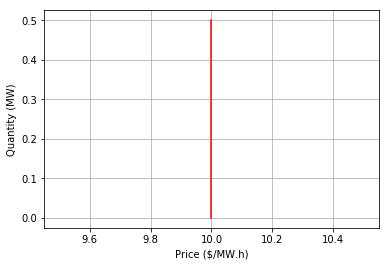

In [9]:
market = ob.orderbook(unit="MW")
print(repr(market))
print(market.ask(quantity=1.0,duration=1.0,price=10.0))
print(market.bid(quantity=0.5,duration=0.5))
market.plot(using={"grid":""})

# Ramping Services
Up to this point we have described a real-time capacity dispatch market.  We now illustrate a real-time ramping services market. In this case, the unit of quantity is `MW/h`.  Because the unit of time is still `h`, the unit of price is thus `$/(MW/h).h` or more simply `$/MW`.

## Examples

The following example creates a ramping market and add limits orders to the market. Because the price unit is reduced from `$/(MW/h).h` to `$/MW`, the price unit is specified explicitly so that the default price unit is not used.

{"buy": [{"quantity": 1.5, "duration": 1.0, "price": 8.0, "id": 21, "ordertype": "BUYLIMIT", "amount": 0.0, "value": 0.0, "divisible": false}, {"quantity": 1.0, "duration": 1.0, "price": 5.0, "id": 22, "ordertype": "BUYLIMIT", "amount": 0.0, "value": 0.0, "divisible": false}, {"quantity": 2.5, "duration": 1.0, "price": 2.0, "id": 23, "ordertype": "BUYLIMIT", "amount": 0.0, "value": 0.0, "divisible": false}], "sell": [{"quantity": 2.0, "duration": 1.0, "price": 10.0, "id": 18, "ordertype": "SELLLIMIT", "amount": 0.0, "value": 0.0, "divisible": true}, {"quantity": 1.0, "duration": 1.0, "price": 15.0, "id": 19, "ordertype": "SELLLIMIT", "amount": 0.0, "value": 0.0, "divisible": true}, {"quantity": 0.5, "duration": 1.0, "price": 20.0, "id": 20, "ordertype": "SELLLIMIT", "amount": 0.0, "value": 0.0, "divisible": true}], "unit": "MW/h", "time": "h", "currency": "$", "price": "$/MW", "using": {}, "fees": 0.0, "settled": []}


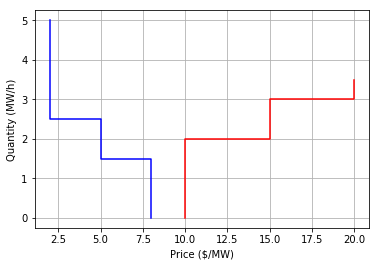

In [10]:
market = ob.orderbook(unit="MW/h",price="$/MW")
market.ask(quantity=2.0, duration=1.0, price=10.0)
market.ask(quantity=1.0, duration=1.0, price=15.0)
market.ask(quantity=0.5, duration=1.0, price=20.0)
market.bid(quantity=1.5, duration=1.0, price=8.0)
market.bid(quantity=1.0, duration=1.0, price=5.0)
market.bid(quantity=2.5, duration=1.0, price=2.0)
print(market)
graph = market.plot(using={"grid":""})

# Validation
The following cases must be validated.
- [ ] Sell limit order booking
- [ ] Divisible buy limit order booking
- [ ] Indivisible buy limit order booking
- [ ] Divisible buy limit order fill with single sell order
- [ ] Divisible buy limit order fill with multiple sell orders
- [ ] Indivisible buy limit order fill with single sell order
- [ ] Indivisible buy limit order fill with multiple sell orders
- [ ] Sell limit order fill with single buy order
- [ ] Sell limit order fill with multiple buy orders
- [ ] Divisible buy market order fill
- [ ] Indivisible buy market order fill
- [ ] Divisible buy market order fill failure
- [ ] Indivisible buy market order fill failure
- [ ] Sell market order fill
- [ ] Sell market order fill failure

The following runs the self-test routine:

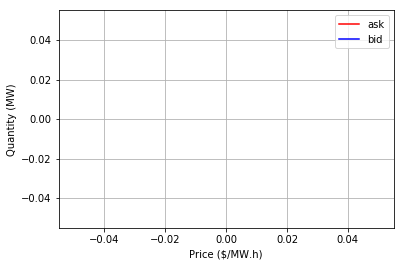

In [11]:
ob.selftest()

# Documentation

In [12]:
help('orderbook')

Help on module orderbook:

NAME
    orderbook - An orderbook is used to implement a real-time market for a transactive energy system.

DESCRIPTION
    A Transactive Energy system may use an Orderbook to implement a continuous market rather 
    than a discrete-time double auction [1].  In an Orderbook, two lists of limit orders are 
    maintained and market orders are filled in real-time.
    
    Limit orders are used to inform the market of the availability of a resource to supply 
    (sell or "ask" order are usually denoted $A$) or consume (buy or "bid" order are usually 
    denoted $B$) a specified quantity of service at a specified price for a specified duration.  
    In general limit orders are used to announce that a resource is potentially available 
    given the right price, but otherwise the resource will not operate.
    
    Market orders are used to obtain from the market an immediate commitment of a resource to 
    supply or consume at the best price possible at the

# References

[1] Hammerstrom et al., "Pacific Northwest Gridwise&trade; Demonstration Testbed: Part I. Olympic 
Peninsula Project", PNNL Report No. 17167, Richland WA, October 2007. 
URL: [https://www.pnnl.gov/main/publications/external/technical_reports/PNNL-17167.pdf]